<a href="https://colab.research.google.com/github/TongshuWu1/RL_CSE337_TonyWu/blob/main/lab11_mbrl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11: Solving the mountaincar problem in 1 episode

In this lab, you will use a Gaussian Process (GP) model to learn the dynamics of the Mountain Car system.
Then, based on Lab 8, you will use MPPI or MPPI-Simplified to write the MPC loop that controls the vehicle.
The goal is to solve the Mountain Car problem in one episode.

## Provided code
* The following code implements a Gaussian Process regression model that predicts the next-state change (Δx) given [position, velocity, action].
* Example training data collected from random actions.



In [ ]:
# %matplotlib widget
%matplotlib inline

In [ ]:
!pip install gpytorch

# Gaussian Process

In [1]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        Xn = (self.X_train - self.X_mean) / self.X_std
        Yn = (self.Y_train - self.Y_mean) / self.Y_std

        self.Xn, self.Yn = Xn, Yn

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.numpy()
        Y_train = self.Y_train.numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1])

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean, var


# Setup environment and collect initial data

In [2]:
import gymnasium as gym
# import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1.  Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
n_state = env.observation_space.shape[0]    # [position, velocity]
n_action = env.action_space.shape[0]        # 1 continuous action
n_output = 2                                # Δpos, Δvel


# --------------------------------------------------------------
# 2.  Collect initial random data
# --------------------------------------------------------------
data = {'X': [], 'Y': []}

obs, _ = env.reset(seed=0)
for _ in range(200):  # collect 500 transitions
    a = env.action_space.sample()  # random continuous action in [-1,1]
    x_next, r, term, trunc, _ = env.step(a)
    data['X'].append(np.concatenate([obs, a]))   # [pos, vel, action]
    data['Y'].append(x_next - obs)               # Δstate
    obs = x_next
    if term or trunc:
        obs, _ = env.reset()

X = np.array(data['X'])[::3]
Y = np.array(data['Y'])[::3]
print(f"Collected {len(X)} transitions.")


# --------------------------------------------------------------
# 3.  Train GP dynamics models
# --------------------------------------------------------------
gps = [GPManager(kernel='RBF', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")


Collected 67 transitions.
Trained GP for Δstate[0] with 67 samples.
Trained GP for Δstate[1] with 67 samples.


# Visualize collected data

Plotting for action a=-1.0
Values near action a=-1.0 n=15


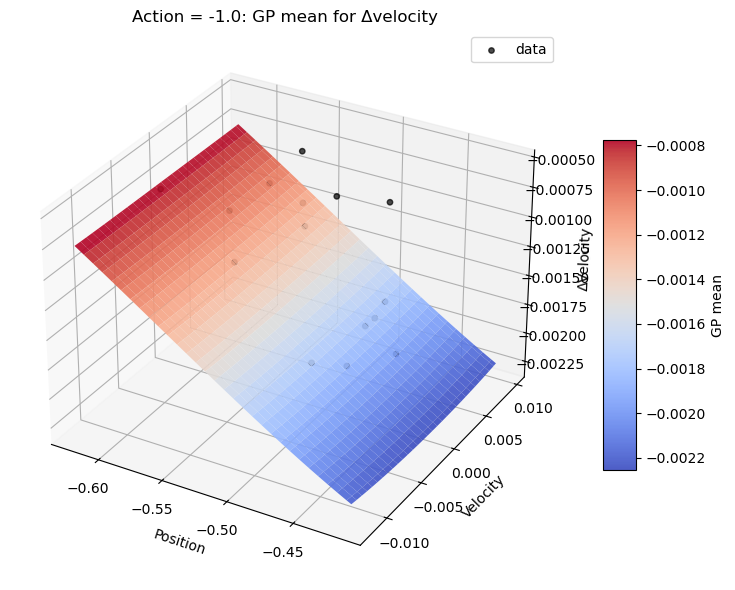

Plotting for action a=0.0
Values near action a=0.0 n=29


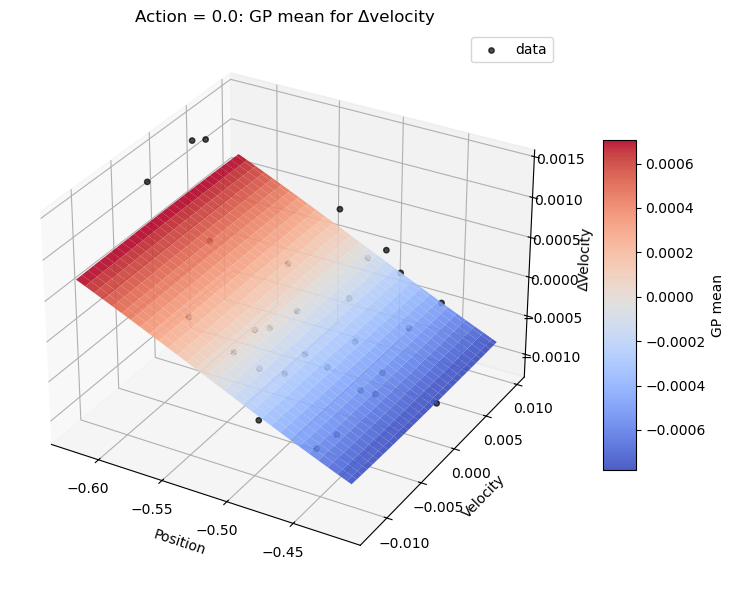

Plotting for action a=1.0
Values near action a=1.0 n=23


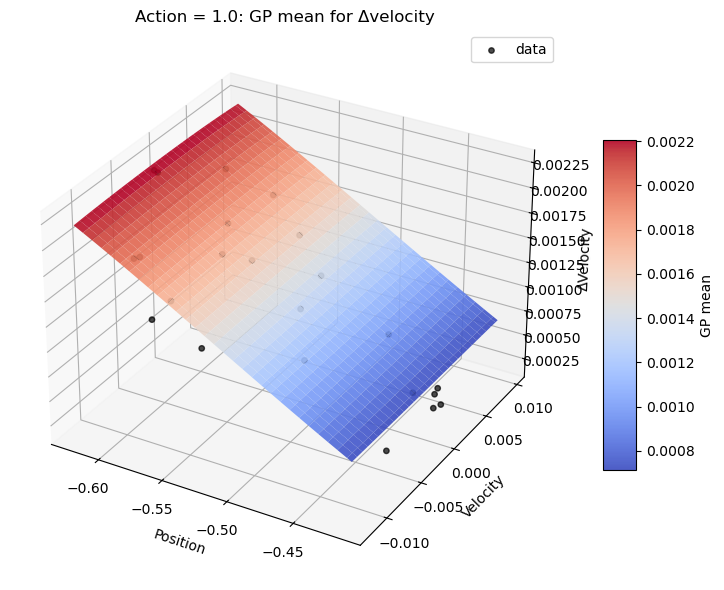

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Visualization setup
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity
a_values = [-1.0, 0.0, 1.0]  # representative actions

# Get raw training data
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train  # Δvelocity targets

# --------------------------------------------------------
# Define grid for visualization
# --------------------------------------------------------
p_min, p_max = pos.min(), pos.max()
v_min, v_max = vel.min(), vel.max()

p_grid = np.linspace(p_min, p_max, 60)
v_grid = np.linspace(v_min, v_max, 60)
P, V = np.meshgrid(p_grid, v_grid)

# --------------------------------------------------------
# Generate and plot for each action
# --------------------------------------------------------
for a_fixed in a_values:
    print(f"Plotting for action a={a_fixed}")

    # Predict using the GP for this action
    X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])
    Mean, var = gp.predict(X_grid)
    Mean = Mean.reshape(P.shape)

    # --------------------------------------------------------
    # Plot as surface
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, V, Mean, cmap='coolwarm',
                           linewidth=0, antialiased=True, alpha=0.9)

    # Overlay training data close to this action value
    mask = np.abs(act - a_fixed) < 0.5
    print(f"Values near action a={a_fixed} n={np.sum(mask)}")
    ax.scatter(pos[mask], vel[mask], dvel[mask],
               color='k', s=15, alpha=0.7, label='data')

    # --------------------------------------------------------
    # Labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('ΔVelocity')
    ax.set_title(f"Action = {a_fixed:.1f}: GP mean for Δvelocity")

    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


Values near action a=-1.0 → n=15


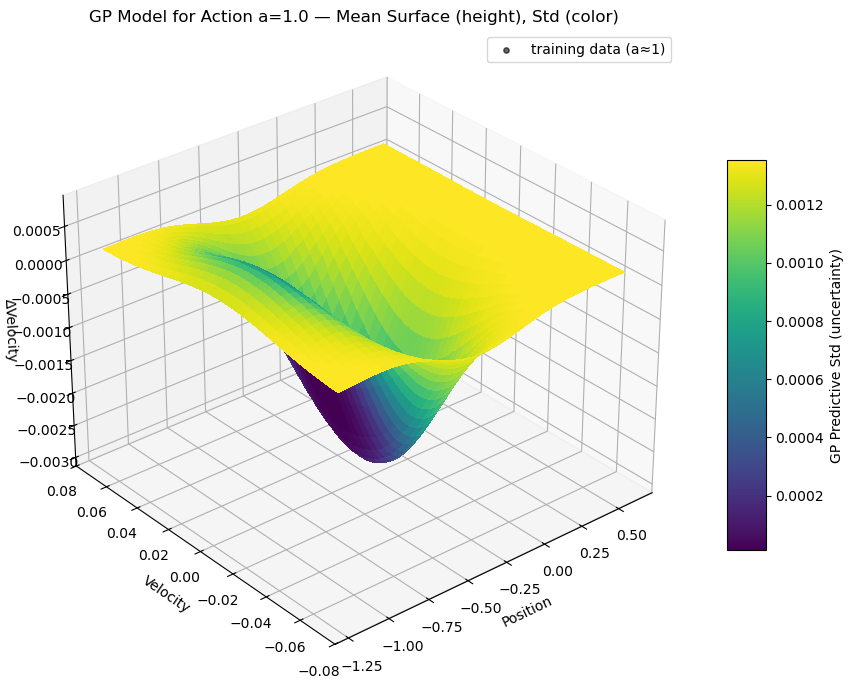

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------
# Choose which GP to visualize
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity (index 0 for Δposition)
a_fixed = -1.0 # fixed continuous action (maximum thrust)

# --------------------------------------------------------
# Get training data
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train

# Select samples close to a=1 for overlay
mask = np.abs(act - a_fixed) < 0.5
print(f"Values near action a={a_fixed} → n={np.sum(mask)}")

# --------------------------------------------------------
# Define position–velocity grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
v_min, v_max = -0.07, 0.07
p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# Query points for the fixed action
X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])

# --------------------------------------------------------
# GP predictions
# --------------------------------------------------------
Mean, Var = gp.predict(X_grid)
Mean = Mean.reshape(P.shape)
Std = np.sqrt(Var.reshape(P.shape))

# Normalize Std for color mapping
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, V, Mean,
    facecolors=colors, linewidth=0, antialiased=False, shade=False
)

# Colorbar = predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (uncertainty)')

# Overlay raw data (samples with similar a)
ax.scatter(
    pos[mask], vel[mask], dvel[mask],
    color='k', s=15, alpha=0.6, label='training data (a≈1)'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('ΔVelocity')
ax.set_title("GP Model for Action a=1.0 — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()



 Training GP on current dataset
  GP step  100/500 | loss = -1.4045
  GP step  200/500 | loss = -1.9149
  GP step  300/500 | loss = -2.0381
  GP step  400/500 | loss = -2.0933
  GP step  500/500 | loss = -2.1267
GP trained.


 Training GP on current dataset
  GP step  100/500 | loss = -1.4015
  GP step  200/500 | loss = -1.9093
  GP step  300/500 | loss = -2.0326
  GP step  400/500 | loss = -2.0878
  GP step  500/500 | loss = -2.1215
GP trained.


=== Initial model diagnostics (before progressive training) ===

[Data] N samples = 150
[Data] pos range ≈ [-0.636, -0.386]
[Data] vel range ≈ [-0.013, +0.011]
[Data] u   range ≈ [-0.999, +0.995]


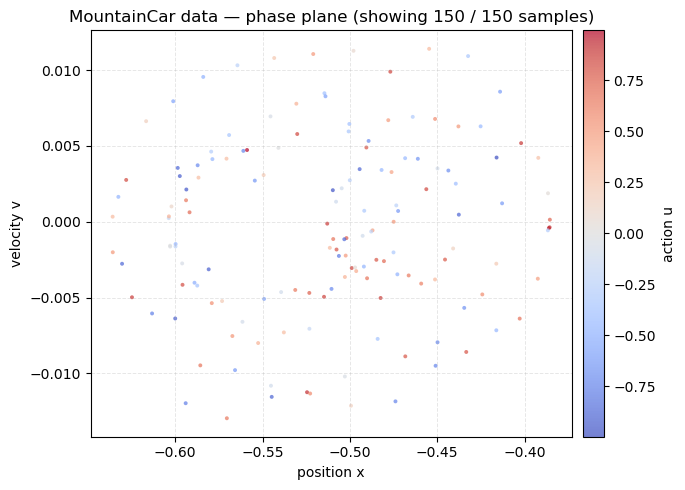

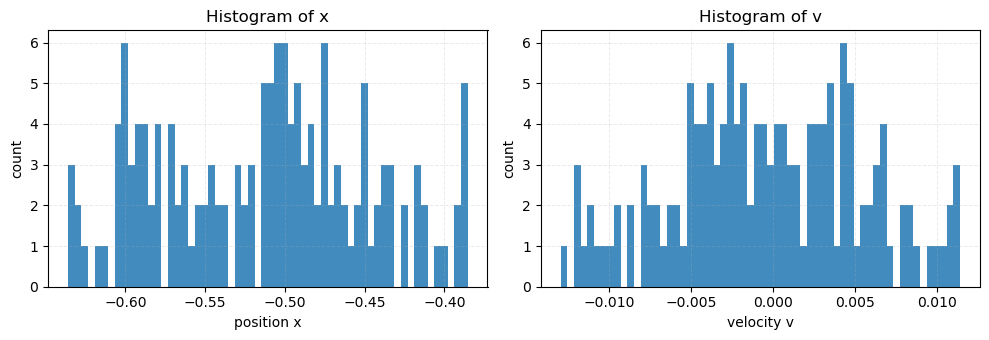


=== Model Analysis (after retrain) ===
[Δpos GP] lengthscales (pos, vel, act): [6.2086 3.63   6.1705]  | outputscale: 2.3508  | noise: 0.001041
[Δvel GP] lengthscales (pos, vel, act): [5.8998 6.2769 4.0822]  | outputscale: 2.8979  | noise: 0.001041
Uncertainty summary over grid (11025 pts): mean=0.000049, std=0.000029, min=0.000000, max=0.000079



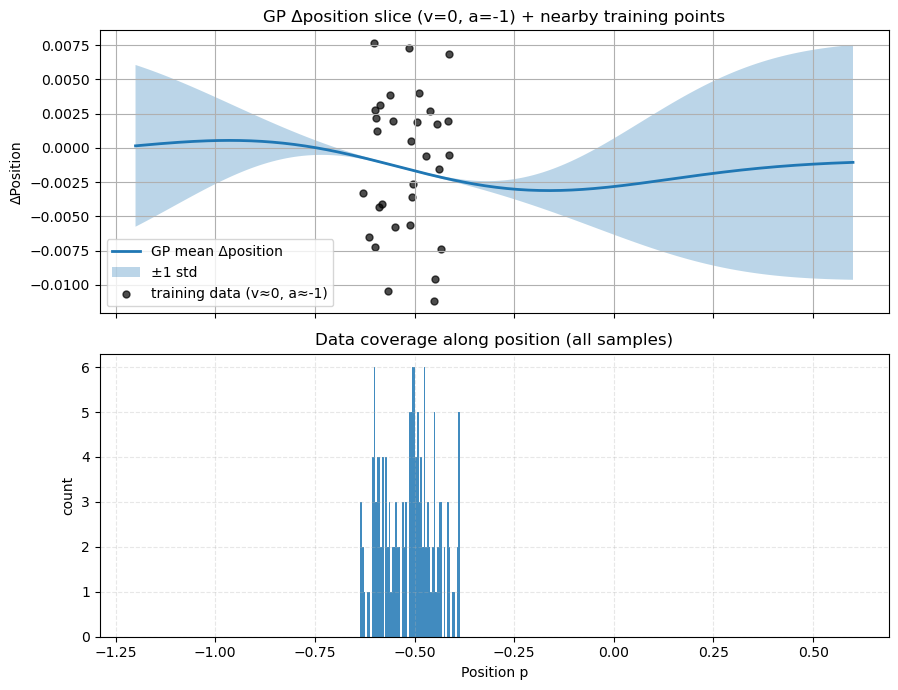


===== TRAINING CYCLE 1/5 =====
Running TaskMPPI from start for up to 40 steps.
[MPPI] step=0  a0=+0.067  Jmin=12553.02
[MPPI] step=10  a0=+0.000  Jmin=12266.54
[MPPI] step=20  a0=-0.570  Jmin=12037.66
[MPPI] step=30  a0=-0.800  Jmin=11670.21
[Main] downsampled 1/4: kept 10/40 main samples
  Main run steps this cycle: 40
  Total training steps so far: 40
  Frontier state x=-0.791, v=-0.012
[MPPI] step=0  a0=-0.089  Jmin=359.36
[MPPI] step=10  a0=+0.140  Jmin=224.72
[MPPI] step=20  a0=+0.773  Jmin=73.33
[MPPI] step=30  a0=+0.838  Jmin=-69.35
[MPPI] step=40  a0=+0.851  Jmin=-196.95
[MPPI] step=50  a0=+0.916  Jmin=-334.76
[MPPI] step=60  a0=+0.872  Jmin=256.00
[MPPI] step=70  a0=+0.813  Jmin=102.01
[MPPI] step=80  a0=+0.635  Jmin=-22.14
[MPPI] step=90  a0=+0.909  Jmin=-135.82
[Explore] downsampled 1/2: kept 50/100 exploration samples
Collected exploration samples this cycle (after 1/2 downsample): 50
Total samples after merge: 210
Retraining GPs on all data …

 Training GP on current data

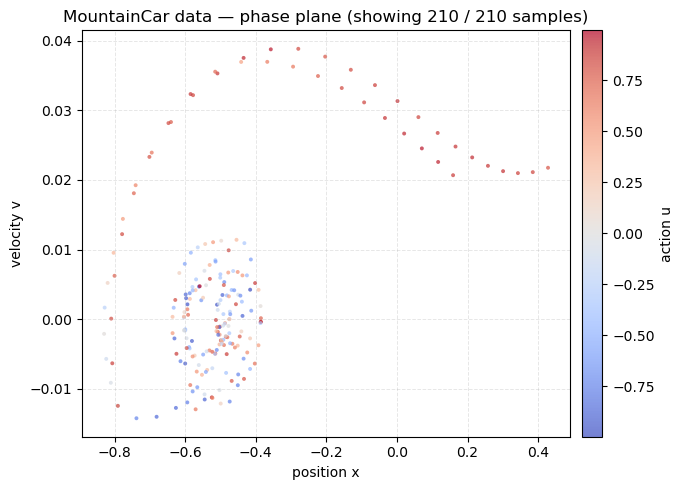

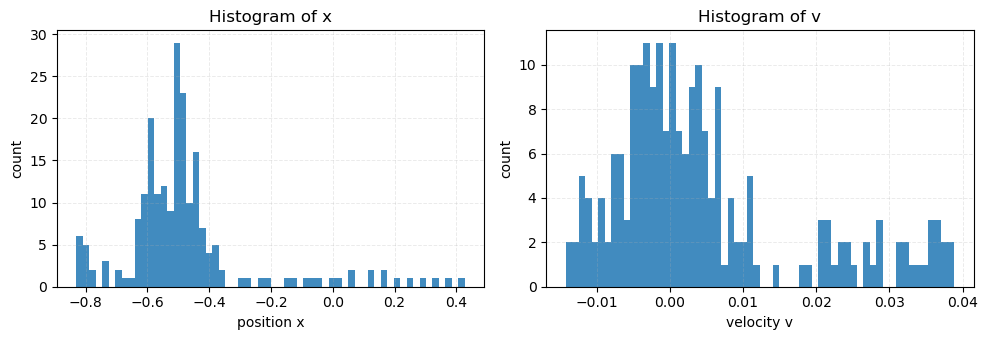


=== Model Analysis (after retrain) ===
[Δpos GP] lengthscales (pos, vel, act): [5.6176 3.8773 6.423 ]  | outputscale: 2.7914  | noise: 0.001049
[Δvel GP] lengthscales (pos, vel, act): [3.1756 6.6364 5.3073]  | outputscale: 4.44  | noise: 0.001049
Uncertainty summary over grid (11025 pts): mean=0.000024, std=0.000038, min=0.000000, max=0.000228



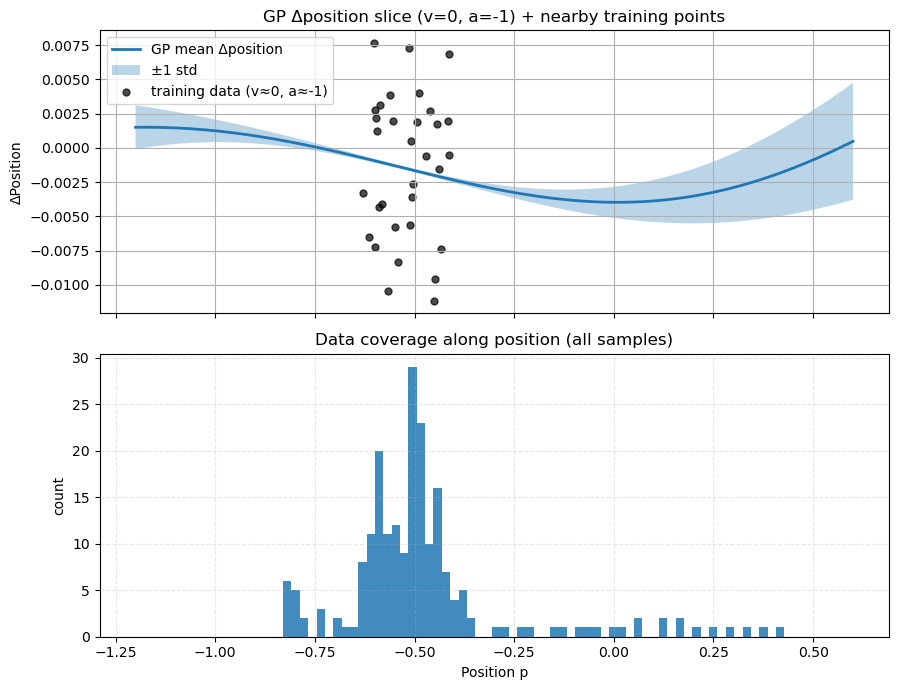


===== TRAINING CYCLE 2/5 =====
Running TaskMPPI from start for up to 80 steps.
[MPPI] step=0  a0=-0.057  Jmin=12514.33
[MPPI] step=10  a0=+0.256  Jmin=12298.68
[MPPI] step=20  a0=+0.128  Jmin=11815.65
[MPPI] step=30  a0=-0.682  Jmin=9582.95
[MPPI] step=40  a0=-0.280  Jmin=10435.37
[MPPI] step=50  a0=-0.784  Jmin=11162.00
[MPPI] step=60  a0=-0.823  Jmin=11672.81
[MPPI] step=70  a0=-0.970  Jmin=11662.59
[Main] downsampled 1/4: kept 20/80 main samples
  Main run steps this cycle: 80
  Total training steps so far: 120
  Frontier state x=-0.772, v=+0.001
[MPPI] step=0  a0=-0.188  Jmin=475.04
[MPPI] step=10  a0=+0.370  Jmin=301.61
[MPPI] step=20  a0=+0.919  Jmin=171.23
[MPPI] step=30  a0=+0.952  Jmin=27.29
[MPPI] step=40  a0=+0.962  Jmin=-117.76
[MPPI] step=50  a0=+0.970  Jmin=-463.11
[MPPI] step=60  a0=+0.974  Jmin=-725.02
[MPPI] step=70  a0=+0.881  Jmin=305.63
[MPPI] step=80  a0=+0.969  Jmin=100.04
[MPPI] step=90  a0=+0.977  Jmin=-292.30
[Explore] downsampled 1/2: kept 50/100 exploration 

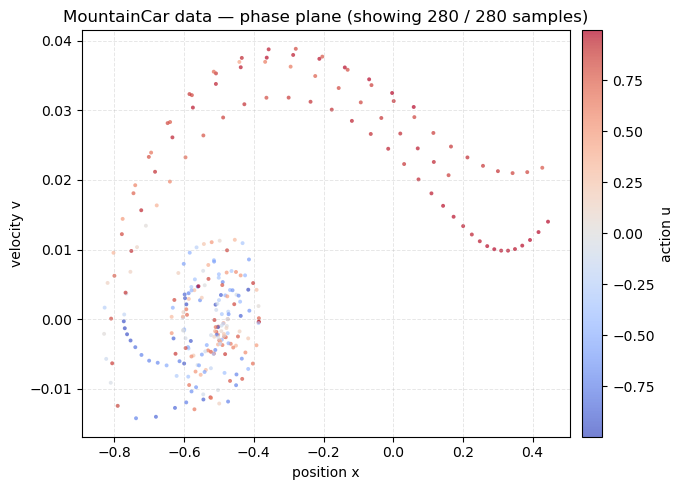

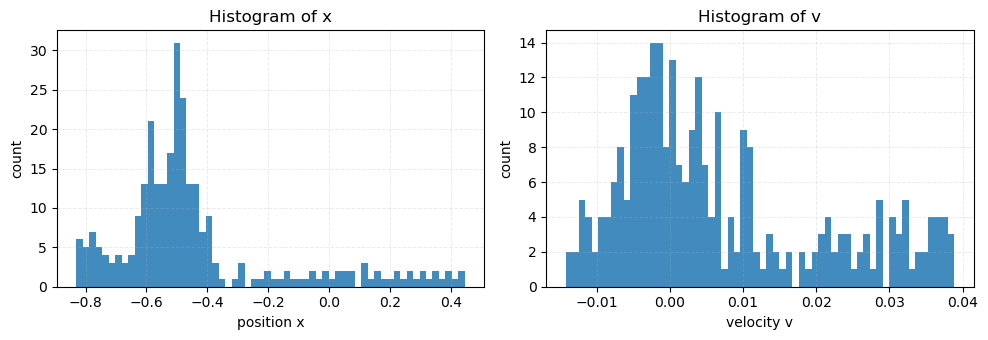


=== Model Analysis (after retrain) ===
[Δpos GP] lengthscales (pos, vel, act): [5.1053 3.7128 6.4484]  | outputscale: 2.7631  | noise: 0.00105
[Δvel GP] lengthscales (pos, vel, act): [2.6123 6.5442 5.3638]  | outputscale: 4.9461  | noise: 0.00105
Uncertainty summary over grid (11025 pts): mean=0.000020, std=0.000035, min=0.000000, max=0.000207



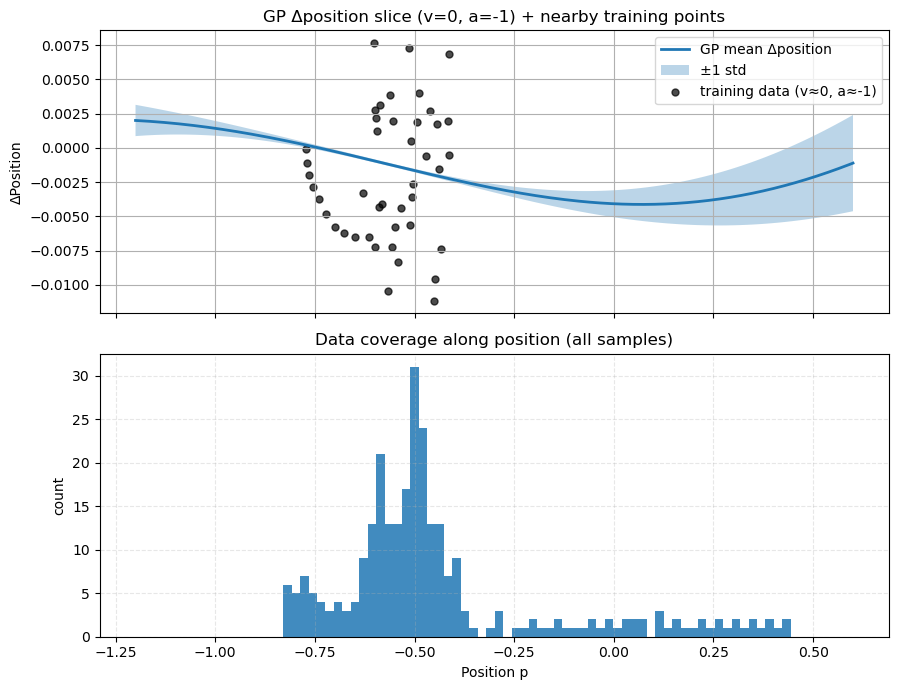


===== TRAINING CYCLE 3/5 =====
Running TaskMPPI from start for up to 120 steps.
[MPPI] step=0  a0=-0.001  Jmin=12538.75
[MPPI] step=10  a0=-0.292  Jmin=12274.29
[MPPI] step=20  a0=-0.278  Jmin=11584.94
[MPPI] step=30  a0=-0.837  Jmin=10950.73
[MPPI] step=40  a0=-0.858  Jmin=10394.20
[MPPI] step=50  a0=-0.838  Jmin=11009.40
[MPPI] step=60  a0=-0.915  Jmin=11391.82
[MPPI] step=70  a0=-0.486  Jmin=11711.63
[MPPI] step=80  a0=+0.227  Jmin=11940.61
[MPPI] step=90  a0=+0.717  Jmin=11800.71
[MPPI] step=100  a0=+0.954  Jmin=11409.23
[MPPI] step=110  a0=+0.801  Jmin=10617.42
[Main] downsampled 1/4: kept 30/120 main samples
  Main run steps this cycle: 120
  Total training steps so far: 240
  Frontier state x=+0.000, v=-0.004
[MPPI] step=0  a0=-0.090  Jmin=575.66
[MPPI] step=10  a0=-0.740  Jmin=529.24
[MPPI] step=20  a0=-0.841  Jmin=510.73
[MPPI] step=30  a0=-0.785  Jmin=622.94
[MPPI] step=40  a0=-0.147  Jmin=516.23
[MPPI] step=50  a0=+0.279  Jmin=126.47
[MPPI] step=60  a0=+0.853  Jmin=-193.19


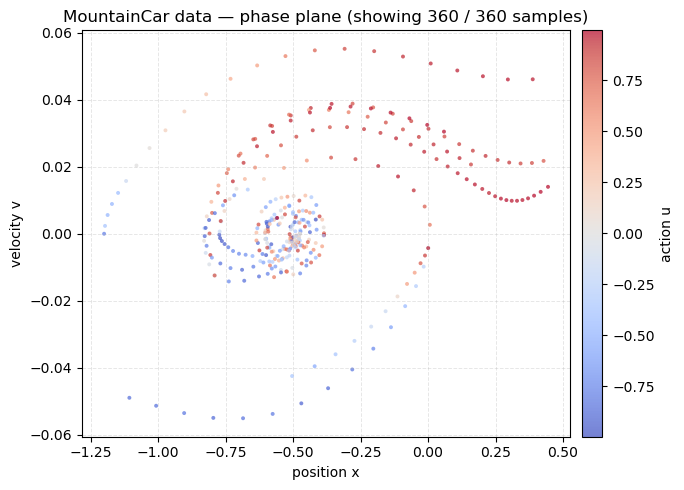

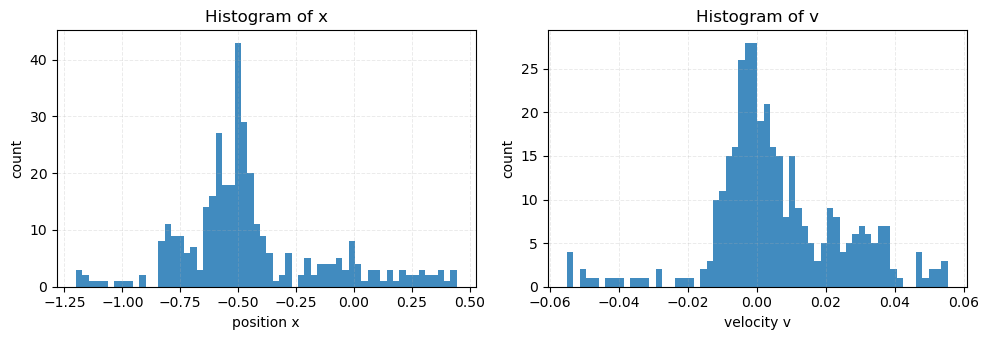


=== Model Analysis (after retrain) ===
[Δpos GP] lengthscales (pos, vel, act): [5.1632 4.6594 6.3221]  | outputscale: 3.9827  | noise: 0.00105
[Δvel GP] lengthscales (pos, vel, act): [2.4564 6.7027 5.4582]  | outputscale: 4.5576  | noise: 0.00105
Uncertainty summary over grid (11025 pts): mean=0.000003, std=0.000006, min=0.000000, max=0.000063



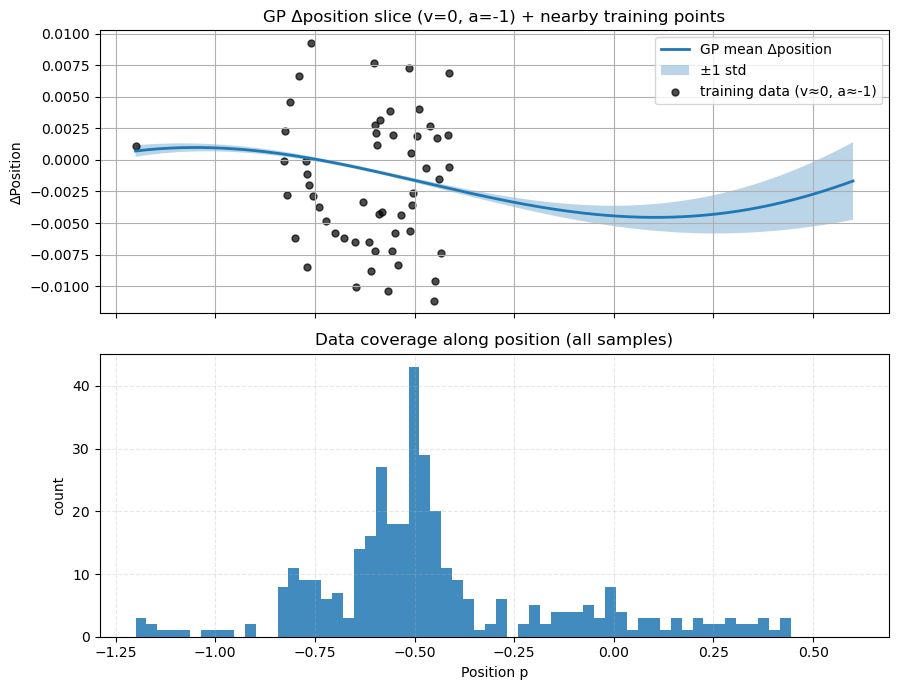


===== TRAINING CYCLE 4/5 =====
Running TaskMPPI from start for up to 160 steps.
[MPPI] step=0  a0=+0.157  Jmin=12520.15
[MPPI] step=10  a0=+0.271  Jmin=12213.82
[MPPI] step=20  a0=+0.443  Jmin=10927.00
[MPPI] step=30  a0=+0.583  Jmin=10183.69
[MPPI] step=40  a0=+0.071  Jmin=9935.81
[MPPI] step=50  a0=-0.515  Jmin=9346.63
[MPPI] step=60  a0=-0.779  Jmin=8418.12
[MPPI] step=70  a0=-0.671  Jmin=7348.95
[MPPI] step=80  a0=-0.364  Jmin=6274.65
[MPPI] step=90  a0=-0.348  Jmin=4844.30
[MPPI] step=100  a0=+0.692  Jmin=3579.64
[MPPI] step=110  a0=+0.953  Jmin=1883.45
[MPPI] step=120  a0=+0.993  Jmin=380.21
Main training trajectory hit GOAL at total_step=369.
[Main] downsampled 1/4: kept 33/129 main samples
  Main run steps this cycle: 129
  Total training steps so far: 369
  Frontier state x=+0.472, v=+0.039
Stopping further training cycles; going to final evaluation.

=== Training phase complete. ===
Total training steps (main runs only): 369
Total samples in dataset: 360
[SAVE] GP dynamics s

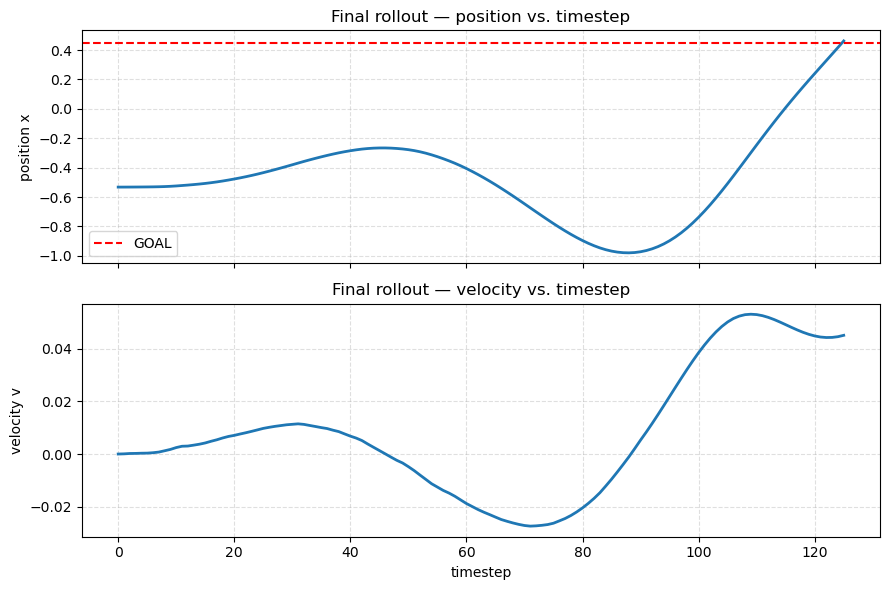


RESULTS:
  Training steps: 369
  FINAL rollout success: True
  FINAL rollout steps: 125


In [8]:
# %matplotlib inline

import os
import numpy as np
import torch
import gpytorch
import gymnasium as gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# ============================================================
# 1) GP model + manager
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        else:
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )


class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=500,
                 dtype=torch.float64, base_jitter=1e-4):
        """
        GP wrapper with:
          - standardization of X and Y
          - higher precision (float64) for stability
          - fixed cholesky jitter during train + predict
        """
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.dtype = dtype
        self.base_jitter = base_jitter

    def fit(self, X, Y):
        print("\n==============================")
        print(" Training GP on current dataset")
        print("==============================")

        # Store as float32 numpy; convert to torch below
        self._train_X_np = np.asarray(X, dtype=np.float32)
        self._train_Y_np = np.asarray(Y, dtype=np.float32)

        X = torch.tensor(self._train_X_np, dtype=self.dtype)
        Y = torch.tensor(self._train_Y_np, dtype=self.dtype)

        # Standardize inputs
        self.X_mean = X.mean(0)
        self.X_std  = X.std(0).clamp_min(1e-8)
        Xn = (X - self.X_mean) / self.X_std

        # Standardize targets
        self.Y_mean = Y.mean()
        self.Y_std  = Y.std().clamp_min(1e-8)
        Yn = (Y - self.Y_mean) / self.Y_std

        # Likelihood with a slightly larger noise floor
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.register_constraint(
            "raw_noise", gpytorch.constraints.GreaterThan(1e-3)
        )
        # reasonable initial noise in standardized space
        self.likelihood.initialize(noise=0.05)
        self.likelihood = self.likelihood.to(self.dtype)

        # Model
        self.model = ExactGPModel(
            Xn, Yn, self.likelihood,
            kernel=self.kernel, ard_dims=X.shape[-1]
        ).to(self.dtype)

        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        self.model.train()
        self.likelihood.train()
        self.loss_track = []

        # Use a fixed jitter during training
        with gpytorch.settings.cholesky_jitter(self.base_jitter):
            for i in range(self.iters):
                opt.zero_grad()
                pred = self.model(Xn)
                loss = -mll(pred, Yn)
                loss.backward()
                opt.step()
                self.loss_track.append(loss.item())
                if (i + 1) % 100 == 0:
                    print(f"  GP step {i+1:4d}/{self.iters} | loss = {loss.item():.4f}")

        self.model.eval()
        self.likelihood.eval()
        print("GP trained.\n")

    def predict_mean_var(self, X):
        X = torch.tensor(X, dtype=self.dtype)
        Xn = (X - self.X_mean) / self.X_std

        with torch.no_grad(), gpytorch.settings.cholesky_jitter(self.base_jitter):
            pred = self.model(Xn)

        mean = pred.mean.cpu().numpy() * float(self.Y_std) + float(self.Y_mean)
        var  = pred.variance.cpu().numpy() * (float(self.Y_std) ** 2)
        return mean, var


# ============================================================
# 2) Initial random data collection
# ============================================================

SEED = 7
rng = np.random.RandomState(SEED)

env_init = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
dataX, dataY = [], []
obs, _ = env_init.reset(seed=SEED)
for _ in range(300):
    a = env_init.action_space.sample()
    next_obs, _, term, trunc, _ = env_init.step(a)
    dataX.append(np.array([obs[0], obs[1], float(a[0])], dtype=np.float32))
    dataY.append(next_obs - obs)
    obs = next_obs
    if term or trunc:
        obs, _ = env_init.reset()
env_init.close()

X = np.asarray(dataX, dtype=np.float32)[::2]
Y = np.asarray(dataY, dtype=np.float32)[::2]

gps = [GPManager(), GPManager()]
gps[0].fit(X, Y[:, 0])  # Δposition
gps[1].fit(X, Y[:, 1])  # Δvelocity


DEFAULT_SAVE_PATH = "mc_gp_dynamics_final.pt"

def save_gp_dynamics(path=DEFAULT_SAVE_PATH):
    global gps, X, Y, GOAL, TASK_W, SEED
    obj = {"gp_pos": gps[0], "gp_vel": gps[1], "X": X, "Y": Y,
           "GOAL": GOAL, "TASK_W": TASK_W, "SEED": SEED}
    torch.save(obj, path)
    print(f"[SAVE] GP dynamics saved to '{path}' (N={len(X)} samples).")

def load_gp_dynamics(path=DEFAULT_SAVE_PATH, map_location="cpu"):
    global gps, X, Y, GOAL, TASK_W, SEED
    obj = torch.load(path, map_location=map_location)
    gps = [obj["gp_pos"], obj["gp_vel"]]
    X = obj.get("X", None); Y = obj.get("Y", None)
    if "GOAL" in obj: GOAL = obj["GOAL"]
    if "TASK_W" in obj: TASK_W = obj["TASK_W"]
    if "SEED" in obj: SEED = obj["SEED"]
    print(f"[LOAD] GP dynamics loaded from '{path}'. Samples in X: {None if X is None else len(X)}")


def gp_step_mean_var(states, actions):
    """
    states: (N,2) [pos, vel]
    actions: (N,) in [-1,1]
    returns: next_states (N,2), total_var (N,)
    """
    N = states.shape[0]
    inp = np.zeros((N, 3), dtype=np.float32)
    inp[:, :2] = states
    inp[:, 2]  = actions

    mean_p, var_p = gps[0].predict_mean_var(inp)
    mean_v, var_v = gps[1].predict_mean_var(inp)

    next_states = states.copy()
    next_states[:, 0] += mean_p
    next_states[:, 1] += mean_v
    total_var = var_p + var_v
    return next_states, total_var

# ============================================================
# 4) Cost (MountainCar-style: distance-to-goal + time + (optional) vel)
# ============================================================

GOAL = 0.45
TASK_W = dict(position=200.0, velocity=0.0, time=1.0)

def task_cost(states, actions, w):
    x = states[:, 0]; v = states[:, 1]
    dist_to_goal = np.maximum(GOAL - x, 0.0)                 # only care when left of goal
    pos_cost = w["position"] * (np.tanh(3.0 * dist_to_goal) ** 2)
    vel_cost = w["velocity"] * (v ** 2)
    time_cost = w["time"]
    return pos_cost + vel_cost + time_cost


class MPPIController:
    def __init__(self, H, K, sigma, lam, gamma,
                 wt_task=1.0, wt_explore=0.0,
                 frontier_state=None, explore_alpha=0.0):
        self.H, self.K = int(H), int(K)
        self.sigma, self.lam, self.gamma = float(sigma), float(lam), float(gamma)
        self.wt_task, self.wt_explore = float(wt_task), float(wt_explore)
        self.U_mean = np.zeros(self.H, dtype=np.float32)
        self.frontier_state = None if frontier_state is None else np.array(frontier_state, dtype=np.float32)
        self.explore_alpha = float(explore_alpha)
        self.debug_step = 0

    def action(self, state):
        noise = rng.randn(self.K, self.H).astype(np.float32) * self.sigma
        U = np.clip(self.U_mean + noise, -1.0, 1.0)

        S = np.repeat(state[None, :], self.K, axis=0)
        J_task = np.zeros(self.K, dtype=np.float64)
        J_expl = np.zeros(self.K, dtype=np.float64)
        disc = 1.0

        for t in range(self.H):
            a_t = U[:, t]
            S, var = gp_step_mean_var(S, a_t)

            if self.wt_task != 0.0:
                J_task += task_cost(S, a_t, TASK_W) * disc

            if self.wt_explore != 0.0:
                # clip variance to avoid log(0) / log(negative)
                var_clipped = np.clip(var, 1e-8, None)

                # exploration term: encourage high-variance regions
                explore_term = -np.log(var_clipped)

                # optional frontier push: reward going to the right of current frontier
                if self.frontier_state is not None and self.explore_alpha > 0.0:
                    x_f = float(self.frontier_state[0])
                    x   = S[:, 0]
                    forward = np.maximum(0.0, x - x_f)  # reward going beyond frontier
                    explore_term += -self.explore_alpha * forward

                J_expl += explore_term * disc

            disc *= self.gamma

        J = self.wt_task * J_task + self.wt_explore * J_expl

        Jmin = J.min()
        w = np.exp(-(J - Jmin) / (self.lam + 1e-8))
        w /= w.sum()

        new_mean = np.sum(U * w[:, None], axis=0)
        self.U_mean = 0.8 * self.U_mean + 0.2 * new_mean

        if (self.debug_step % 10) == 0:
            print(f"[MPPI] step={self.debug_step}  a0={self.U_mean[0]:+.3f}  Jmin={Jmin:.2f}")
        self.debug_step += 1
        return float(self.U_mean[0])


TaskMPPI = lambda: MPPIController(
    H=100, K=600, sigma=0.6, lam=1.0, gamma=0.99,
    wt_task=1.0, wt_explore=0.0, frontier_state=None, explore_alpha=0.0
)

def ExploreMPPI(frontier_state):
    return MPPIController(
        H=60, K=256, sigma=0.75, lam=1.0, gamma=0.99,
        wt_task=0.0, wt_explore=1.0,
        frontier_state=frontier_state, explore_alpha=15.0,
    )

# ============================================================
# 6) (Optional) diagnostics / plots
# ============================================================

def plot_data_distribution(max_points=20000):
    global X
    if X is None or X.shape[0] == 0:
        print("[plot_data_distribution] No data in X yet, skipping plot.")
        return
    pos, vel, u = X[:,0], X[:,1], X[:,2]
    N = pos.shape[0]
    print(f"\n[Data] N samples = {N}")
    print(f"[Data] pos range ≈ [{pos.min():+.3f}, {pos.max():+.3f}]")
    print(f"[Data] vel range ≈ [{vel.min():+.3f}, {vel.max():+.3f}]")
    print(f"[Data] u   range ≈ [{u.min():+.3f}, {u.max():+.3f}]")

    if N > max_points:
        rng_vis = np.random.default_rng(0)
        idx = rng_vis.choice(N, size=max_points, replace=False)
        N_show = max_points
    else:
        idx = slice(None); N_show = N

    plt.figure(figsize=(7,5))
    sc = plt.scatter(pos[idx], vel[idx], c=u[idx], s=8, cmap="coolwarm", alpha=0.7, edgecolors="none")
    plt.xlabel("position x"); plt.ylabel("velocity v")
    plt.title(f"MountainCar data — phase plane (showing {N_show:,} / {N:,} samples)")
    plt.grid(True, alpha=0.3, linestyle="--", linewidth=0.7)
    cb = plt.colorbar(sc, pad=0.02); cb.set_label("action u")
    plt.tight_layout(); plt.show()

    fig, axes = plt.subplots(1,2, figsize=(10,3.5))
    axes[0].hist(pos, bins=60, alpha=0.85); axes[0].set_xlabel("position x"); axes[0].set_ylabel("count"); axes[0].set_title("Histogram of x")
    axes[1].hist(vel, bins=60, alpha=0.85); axes[1].set_xlabel("velocity v"); axes[1].set_ylabel("count"); axes[1].set_title("Histogram of v")
    for ax in axes: ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.7)
    plt.tight_layout(); plt.show()

def plot_uncertainty():
    gp = gps[0]  # Δposition GP
    p_grid = np.linspace(-1.2, 0.6, 200, dtype=np.float32)
    v_fixed, a_fixed = 0.0, -1.0
    Xq = np.column_stack([p_grid, np.full_like(p_grid, v_fixed), np.full_like(p_grid, a_fixed)])
    Mean, Var = gp.predict_mean_var(Xq); Std = np.sqrt(Var)

    X_train = X; Y_train = Y[:,0]
    mask = (np.abs(X_train[:,1]-v_fixed) < 0.01) & (np.abs(X_train[:,2]-a_fixed) < 0.5)
    pos_all = X_train[:,0]

    fig, axes = plt.subplots(2,1, figsize=(9,7), sharex=True)
    ax0 = axes[0]
    ax0.plot(p_grid, Mean, lw=2, label="GP mean Δposition")
    ax0.fill_between(p_grid, Mean-Std, Mean+Std, alpha=0.30, label="±1 std")
    if np.any(mask):
        ax0.scatter(X_train[mask,0], Y_train[mask], color='k', s=25, alpha=0.7, label='training data (v≈0, a≈-1)')
    ax0.set_ylabel("ΔPosition"); ax0.set_title("GP Δposition slice (v=0, a=-1) + nearby training points"); ax0.grid(True); ax0.legend()

    ax1 = axes[1]
    ax1.hist(pos_all, bins=60, alpha=0.85)
    ax1.set_xlabel("Position p"); ax1.set_ylabel("count"); ax1.set_title("Data coverage along position (all samples)")
    ax1.grid(True, alpha=0.3, linestyle="--")
    plt.tight_layout(); plt.show()

def print_model_analysis():
    def hp_str(gpm):
        m = gpm.model
        with torch.no_grad():
            ls = m.covar_module.base_kernel.lengthscale.flatten().cpu().numpy()
            os = float(m.covar_module.outputscale.cpu())
            nz = float(gpm.likelihood.noise_covar.noise.cpu())
        return ls, os, nz
    ls0, os0, n0 = hp_str(gps[0]); ls1, os1, n1 = hp_str(gps[1])
    print("\n=== Model Analysis (after retrain) ===")
    print("[Δpos GP] lengthscales (pos, vel, act):", np.round(ls0,4), " | outputscale:", round(os0,4), " | noise:", round(n0,6))
    print("[Δvel GP] lengthscales (pos, vel, act):", np.round(ls1,4), " | outputscale:", round(os1,4), " | noise:", round(n1,6))
    pos = np.linspace(-1.2, 0.6, 25, dtype=np.float32)
    vel = np.linspace(-0.07, 0.07, 21, dtype=np.float32)
    act = np.linspace(-1.0, 1.0, 21, dtype=np.float32)
    PP, VV, AA = np.meshgrid(pos, vel, act, indexing='ij')
    grid = np.stack([PP.ravel(), VV.ravel(), AA.ravel()], axis=1)
    _, var_p = gps[0].predict_mean_var(grid); _, var_v = gps[1].predict_mean_var(grid)
    tot = var_p + var_v
    print(f"Uncertainty summary over grid ({len(grid)} pts): mean={tot.mean():.6f}, std={tot.std():.6f}, min={tot.min():.6f}, max={tot.max():.6f}\n")

def plot_gp_surface_for_action(action_val=1.0, which='vel', a_tolerance=0.15):
    idx = 1 if which == 'vel' else 0
    gp = gps[idx]
    pos = np.linspace(-1.2, 0.6, 61, dtype=np.float32)
    vel = np.linspace(-0.07, 0.07, 61, dtype=np.float32)
    P, V = np.meshgrid(pos, vel, indexing='ij')
    A = np.full(P.size, float(action_val), dtype=np.float32)
    grid = np.column_stack([P.ravel(), V.ravel(), A])
    Mean, Var = gp.predict_mean_var(grid); Mean = Mean.reshape(P.shape); Std = np.sqrt(Var).reshape(P.shape)
    mask = np.abs(X[:,2] - action_val) <= a_tolerance
    pos_tr, vel_tr = X[mask,0], X[mask,1]
    dpos_tr, dvel_tr = Y[mask,0], Y[mask,1]
    dZ = dvel_tr if idx == 1 else dpos_tr

    norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
    colors = plt.cm.viridis(norm(Std))
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(P, V, Mean, facecolors=colors, linewidth=0, antialiased=False, shade=False)
    m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    m.set_array(Std)
    cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10); cbar.set_label('GP Predictive Std (uncertainty)')
    if pos_tr.size > 0:
        ax.scatter(pos_tr, vel_tr, dZ, color='k', s=15, alpha=0.6, label=f"training data (a≈{action_val})")
    ax.set_xlabel('Position'); ax.set_ylabel('Velocity'); ax.set_zlabel('ΔVelocity' if idx==1 else 'ΔPosition')
    ax.set_title(f"GP Model for Action a={action_val:.2f} — Mean Surface (height), Std (color)")
    ax.view_init(elev=30, azim=230)
    if pos_tr.size > 0: ax.legend()
    plt.tight_layout(); plt.show()


def exploration_rollout_from(frontier_state, n_steps=500, use_mppi=True, seed=123):
    """
    Run exploration starting from frontier_state.
    Keep exactly 1 out of every 2 samples (deterministic downsample).
    """
    env = gym.make("MountainCarContinuous-v0")
    env.reset(seed=seed)
    env.unwrapped.state = np.array(frontier_state, dtype=np.float32)

    newX, newY = [], []
    s = np.array(frontier_state, dtype=np.float32)
    ctrl = ExploreMPPI(frontier_state) if use_mppi else None

    for _ in range(n_steps):
        if use_mppi:
            a = ctrl.action(s)
        else:
            A = np.linspace(-1.0, 1.0, 21, dtype=np.float32)
            S_t = np.repeat(s[None, :], len(A), axis=0)
            _, var_grid = gp_step_mean_var(S_t, A)
            a = float(A[np.argmax(var_grid)])

        s_next, _, term, trunc, _ = env.step([a])

        newX.append(np.array([s[0], s[1], a], dtype=np.float32))
        newY.append(s_next - s)

        s = s_next

        if term or trunc:
            env.reset()
            env.unwrapped.state = np.array(frontier_state, dtype=np.float32)
            s = np.array(frontier_state, dtype=np.float32)

    env.close()

    if len(newX) == 0:
        return np.zeros((0,3), dtype=np.float32), np.zeros((0,2), dtype=np.float32)

    newX = np.asarray(newX, dtype=np.float32)
    newY = np.asarray(newY, dtype=np.float32)

    # Downsample: keep 1 out of every 2
    idx = np.arange(newX.shape[0])[::2]  # 0,2,4,...
    X_keep = newX[idx]
    Y_keep = newY[idx]
    print(f"[Explore] downsampled 1/2: kept {X_keep.shape[0]}/{newX.shape[0]} exploration samples")
    return X_keep, Y_keep


def final_task_rollout(max_steps=1000, seed=1234):
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=500, render_mode="human")
    obs, _ = env.reset(seed=seed)
    ctrl = TaskMPPI()
    pos_hist = [float(obs[0])]; vel_hist = [float(obs[1])]; t_hist = [0]
    success = False

    for t in range(1, max_steps + 1):
        a = ctrl.action(obs)
        obs, _, term, trunc, _ = env.step([a])
        pos_hist.append(float(obs[0])); vel_hist.append(float(obs[1])); t_hist.append(t)
        if obs[0] >= GOAL:
            print(f"\n[FINAL] 🎉 SUCCESS: goal reached at step {t}."); success = True; break
        if term or trunc:
            print(f"\n[FINAL] Episode terminated at step {t} without reaching goal."); break

    env.close()

    pos_hist = np.array(pos_hist); vel_hist = np.array(vel_hist); t_hist = np.array(t_hist)
    fig, axes = plt.subplots(2,1, figsize=(9,6), sharex=True)
    axes[0].plot(t_hist, pos_hist, lw=2); axes[0].axhline(GOAL, ls='--', color='r', label='GOAL')
    axes[0].set_ylabel("position x"); axes[0].set_title("Final rollout — position vs. timestep")
    axes[0].grid(True, alpha=0.4, linestyle="--"); axes[0].legend()
    axes[1].plot(t_hist, vel_hist, lw=2); axes[1].set_xlabel("timestep"); axes[1].set_ylabel("velocity v")
    axes[1].set_title("Final rollout — velocity vs. timestep"); axes[1].grid(True, alpha=0.4, linestyle="--")
    plt.tight_layout(); plt.show()

    return dict(success=success, steps=int(t_hist[-1]), pos=pos_hist, vel=vel_hist)


def run_progressive_episode(base_prefix_step=30, explore_steps=100,
                            max_total_steps=1500, n_cycles=5,
                            save_path=DEFAULT_SAVE_PATH):
    global X, Y, gps

    print("\n=== Initial model diagnostics (before progressive training) ===")
    plot_data_distribution(); print_model_analysis(); plot_uncertainty()

    total_steps = 0
    stop_training = False
    env = gym.make("MountainCarContinuous-v0")

    for cyc in range(1, n_cycles + 1):
        if stop_training or total_steps >= max_total_steps: break

        target_prefix = cyc * base_prefix_step
        print(f"\n===== TRAINING CYCLE {cyc}/{n_cycles} =====")
        print(f"Running TaskMPPI from start for up to {target_prefix} steps.")

        obs, _ = env.reset(seed=SEED)
        task_ctrl = TaskMPPI()

        steps_this_run = 0
        frontier_state = obs.copy()

        mainX, mainY = [], []

        # ---- Main run ----
        while steps_this_run < target_prefix and total_steps < max_total_steps:
            a = task_ctrl.action(obs)
            next_obs, _, term, trunc, _ = env.step([a])

            mainX.append(np.array([obs[0], obs[1], float(a)], dtype=np.float32))
            mainY.append(next_obs - obs)

            obs = next_obs
            frontier_state = obs.copy()
            steps_this_run += 1
            total_steps += 1

            if obs[0] >= GOAL:
                print(f"Main training trajectory hit GOAL at total_step={total_steps}.")
                stop_training = True
                break
            if term or trunc:
                print("Env terminated early during main run — breaking.")
                break

        # Convert & downsample main-run: keep 1 out of every 4
        if len(mainX) > 0:
            mainX_arr = np.asarray(mainX, dtype=np.float32)
            mainY_arr = np.asarray(mainY, dtype=np.float32)
            idx_main = np.arange(mainX_arr.shape[0])[::4]  # 0,4,8,... (1/4)
            mainX_keep = mainX_arr[idx_main]
            mainY_keep = mainY_arr[idx_main]
            print(f"[Main] downsampled 1/4: kept {mainX_keep.shape[0]}/{mainX_arr.shape[0]} main samples")
        else:
            mainX_keep = np.zeros((0,3), dtype=np.float32)
            mainY_keep = np.zeros((0,2), dtype=np.float32)

        print(f"  Main run steps this cycle: {steps_this_run}")
        print(f"  Total training steps so far: {total_steps}")
        print(f"  Frontier state x={frontier_state[0]:+.3f}, v={frontier_state[1]:+.3f}")

        if stop_training or total_steps >= max_total_steps:
            print("Stopping further training cycles; going to final evaluation.")
            break

        # ---- Exploration around frontier (keep 1/2) ----
        newX_explore, newY_explore = exploration_rollout_from(
            frontier_state, n_steps=explore_steps, use_mppi=True, seed=SEED + cyc
        )
        print("Collected exploration samples this cycle (after 1/2 downsample):",
              newX_explore.shape[0])

        # ---- Merge & retrain ----
        X_list = [X]; Y_list = [Y]
        if mainX_keep.shape[0] > 0: X_list.append(mainX_keep); Y_list.append(mainY_keep)
        if newX_explore.shape[0] > 0: X_list.append(newX_explore); Y_list.append(newY_explore)

        X = np.vstack(X_list); Y = np.vstack(Y_list)
        print(f"Total samples after merge: {X.shape[0]}")
        print("Retraining GPs on all data …")
        gps[0].fit(X, Y[:, 0]); gps[1].fit(X, Y[:, 1])

        # diagnostics after this cycle
        plot_data_distribution(); print_model_analysis(); plot_uncertainty()

    env.close()
    print("\n=== Training phase complete. ===")
    print(f"Total training steps (main runs only): {total_steps}")
    print(f"Total samples in dataset: {X.shape[0]}")

    if save_path is not None:
        save_gp_dynamics(save_path)

    print("\n=== Running FINAL evaluation rollout with TaskMPPI ===")
    final_results = final_task_rollout(max_steps=1000, seed=SEED + 999)

    return dict(
        training_steps=total_steps,
        final_success=final_results["success"],
        final_steps=final_results["steps"],
        final_pos=final_results["pos"],
        final_vel=final_results["vel"],
    )

# ============================================================
# 10) Run everything
# ============================================================

results = run_progressive_episode(
    base_prefix_step=40,
    explore_steps=100,
    max_total_steps=500,
    n_cycles=5,
    save_path="mc_gp_dynamics_final.pt",
)
print("\nRESULTS:")
print("  Training steps:", results["training_steps"])
print("  FINAL rollout success:", results["final_success"])
print("  FINAL rollout steps:", results["final_steps"])


# Exercise 1
Use the trained GP as a learned dynamics model to control the Mountain Car environment using Model Predictive Control (MPC).

You can choose between:
* MPPI (Model Predictive Path Integral) – probabilistic trajectory weighting, or
* MPPI-Simplified (Random Shooting) – select the lowest-cost trajectory among random samples.

Your controller should plan ahead, predict future states using the GP, and drive the car to reach the goal in a single episode.

### Expected Outcome
By the end of the exercise, your controller should:
* Use the GP model to predict the system dynamics
* Plan and select optimal actions using MPC
* Drive the car to reach the goal in one episode

### Deliverables

* Your implementation of the mpc_action() function
* A plot showing the car’s position versus time
* A short explanation (2–3 sentences) describing how MBRL is more efficient than Q-learning.
* Describe the downside of MBRL over Q-learning

# MPC


In [ ]:
%matplotlib inline

import numpy as np
import torch
import gpytorch
import gymnasium as gym
import matplotlib.pyplot as plt



class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        else:
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )


class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=600):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters

    def fit(self, X, Y):
        print("Training GP (CPU)…")

        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_mean = X.mean(0)
        self.X_std = X.std(0)
        Xn = (X - self.X_mean) / self.X_std

        self.Y_mean = Y.mean()
        self.Y_std = Y.std()
        Yn = (Y - self.Y_mean) / self.Y_std

        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.model = ExactGPModel(Xn, Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=X.shape[-1])

        self.model.train()
        self.likelihood.train()

        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        for i in range(self.iters):
            opt.zero_grad()
            pred = self.model(Xn)
            loss = -mll(pred, Yn)
            loss.backward()
            opt.step()

        self.model.eval()
        self.likelihood.eval()

        print("GP trained.")

    def predict_fast(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad():
            pred = self.model(Xn)
        return pred.mean.numpy() * float(self.Y_std) + float(self.Y_mean)



env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
dataX, dataY = [], []

obs, _ = env.reset(seed=0)
for _ in range(300):
    a = env.action_space.sample()
    next_obs, _, term, trunc, _ = env.step(a)
    dataX.append(np.concatenate([obs, a]))
    dataY.append(next_obs - obs)
    obs = next_obs
    if term or trunc:
        obs, _ = env.reset()

X = np.array(dataX)[::2]
Y = np.array(dataY)[::2]

print("Collected samples:", len(X))

gps = [GPManager(iters=600), GPManager(iters=600)]
gps[0].fit(X, Y[:, 0])
gps[1].fit(X, Y[:, 1])



def gp_step_fast(states, actions):
    N = states.shape[0]
    inp = np.zeros((N, 3), dtype=np.float32)
    inp[:, :2] = states
    inp[:, 2] = actions

    dpos = gps[0].predict_fast(inp)
    dvel = gps[1].predict_fast(inp)

    next_states = np.empty_like(states)
    next_states[:, 0] = states[:, 0] + dpos
    next_states[:, 1] = states[:, 1] + dvel
    return next_states


GOAL = 0.45

STOP_WEIGHTS = dict(
    position=300,
    velocity=200,
    energy=1.0,
    stop_boost=4000.0,
    time=2.0,
)

def cost_map(states, actions, w):
    x = states[:, 0]
    v = states[:, 1]
    dist = np.abs(x - GOAL)

    pos = w["position"] * (np.tanh(dist * 2) ** 2)
    vel = (w["velocity"] + w["stop_boost"] * np.exp(-20 * dist)) * (v ** 2)
    energy = w["energy"] * (actions ** 2)
    time = w["time"]
    steady = np.where((dist < 0.03) & (np.abs(v) < 0.005), -1000.0, 0.0)

    return pos + vel + energy + time + steady


class FastMPPI:
    def __init__(self, gps):
        self.H = 80
        self.K = 512
        self.sigma = 0.6
        self.lam = 1.0
        self.gamma = 0.99
        self.U_mean = np.zeros(self.H, dtype=np.float32)
        self.gps = gps
        self.debug_step = 0

    def action(self, state):
        noise = np.random.randn(self.K, self.H).astype(np.float32) * self.sigma
        U = np.clip(self.U_mean + noise, -1, 1)

        S = np.repeat(state[None, :], self.K, axis=0)
        costs = np.zeros(self.K)
        disc = 1.0

        for t in range(self.H):
            a_t = U[:, t]
            S = gp_step_fast(S, a_t)
            costs += cost_map(S, a_t, STOP_WEIGHTS) * disc
            disc *= self.gamma

        Jmin = costs.min()
        weights = np.exp(-(costs - Jmin) / (self.lam + 1e-6))
        weights /= weights.sum()

        new_mean = np.sum(U * weights[:, None], axis=0)
        self.U_mean = 0.8 * self.U_mean + 0.2 * new_mean

        if self.debug_step % 5 == 0:
            print(f"[MPPI] step={self.debug_step}  a0={self.U_mean[0]:+.3f}  Jmin={Jmin:.2f}")

        self.debug_step += 1
        return float(self.U_mean[0])


def run_mppi_human():
    env = gym.make("MountainCarContinuous-v0", render_mode="human")
    obs, _ = env.reset(seed=0)

    ctrl = FastMPPI(gps)
    pos_hist, vel_hist, act_hist = [], [], []

    for t in range(500):
        a = ctrl.action(obs)
        obs, _, term, trunc, _ = env.step([a])

        pos_hist.append(obs[0])
        vel_hist.append(obs[1])
        act_hist.append(a)

        if term or trunc:
            break

    env.close()
    return np.array(pos_hist), np.array(vel_hist), np.array(act_hist)


pos_hist, vel_hist, act_hist = run_mppi_human()

plt.figure(figsize=(10, 7))

plt.subplot(3, 1, 1)
plt.plot(pos_hist)
plt.axhline(GOAL, color='r', linestyle='--')
plt.ylabel("Position")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(vel_hist)
plt.ylabel("Velocity")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(act_hist)
plt.ylabel("Action")
plt.xlabel("Time Step")
plt.grid(True)

plt.tight_layout()
plt.show()


MBRL is more efficient than Q-learning because it learns a model of the environment and can simulate many future steps without needing real interactions. This lets the agent improve its policy using fewer samples, while Q-learning must collect a lot more experience directly from the environment.

The downside is that MBRL depends on how accurate the learned model is. If the model is wrong, the planner can make bad decisions, while Q-learning is slower but does not suffer from model errors.



# Exercise 2 (Graduate students)
Extend the MPC controller from Exercise 1 by incorporating Gaussian Process (GP) uncertainty into the MPPI algorithm.
The goal is to study how including the GP’s predictive variance affects control performance and sample efficiency.


* Include GP uncertainty (variance) in the MPPI algorithm.
Modify the cost function or trajectory weighting so that trajectories passing through regions of high model uncertainty are penalized.

* Compare two systems:
  * MPPI using only the GP mean prediction (deterministic model).
  * MPPI using both the GP mean and variance (uncertainty-aware model).
* Evaluate and discuss the results:
  * The MBRL system from Exercise 1 usually solves the Mountain Car problem in more than 100 steps, even after several episodes.
  * Investigate whether incorporating uncertainty can help the controller reach the goal faster or with fewer samples.
  * Provide plots of position over time for both cases.

## Deliverables

* Your modified MPPI implementation that includes GP variance.
* Two plots comparing:
    * Position vs. time (with and without variance)
    * Cumulative reward or number of steps to reach the goal
* A short discussion (2–3 paragraphs) explaining how including uncertainty affects performance and why it might lead to better results.

step wise explore and task


 Training GP on current dataset
  GP step  100/500 | loss = -0.4167
  GP step  200/500 | loss = -1.8651
  GP step  300/500 | loss = -2.8035
  GP step  400/500 | loss = -3.0662
  GP step  500/500 | loss = -3.1504
GP trained.


 Training GP on current dataset
  GP step  100/500 | loss = -0.4148
  GP step  200/500 | loss = -1.8615
  GP step  300/500 | loss = -2.8023
  GP step  400/500 | loss = -3.0628
  GP step  500/500 | loss = -3.1435
GP trained.


=== Initial model diagnostics (before progressive training) ===

[Data] N samples = 150
[Data] pos range ≈ [-0.657, -0.386]
[Data] vel range ≈ [-0.011, +0.012]
[Data] u   range ≈ [-0.995, +0.997]


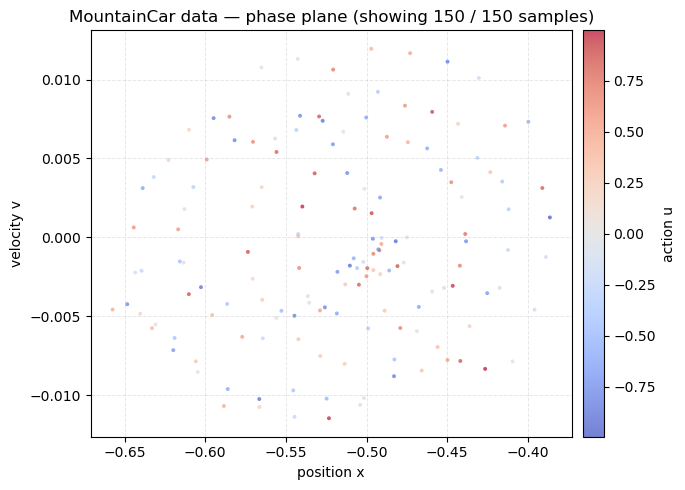

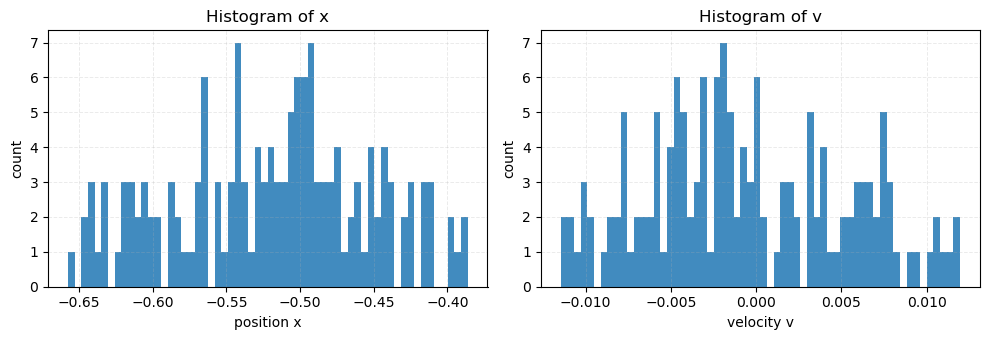


=== Model Analysis (after retrain) ===
[Δpos GP] lengthscales (pos, vel, act): [8.8804 4.7321 8.8472]  | outputscale: 3.7043  | noise: 0.000113
[Δvel GP] lengthscales (pos, vel, act): [8.3614 8.9979 5.7708]  | outputscale: 5.195  | noise: 0.000113
Uncertainty summary over grid (11025 pts): mean=0.000049, std=0.000043, min=0.000000, max=0.000131



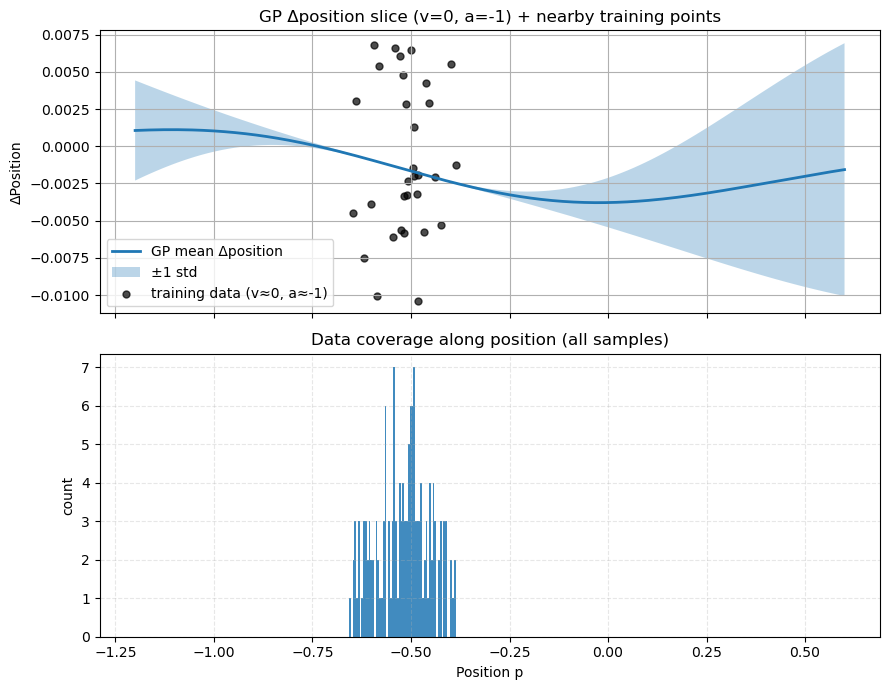


===== TRAINING CYCLE 1/5 =====
Running TaskMPPI from start for up to 40 steps.
[MPPI] step=0  a0=+0.065  Jmin=12552.97
[MPPI] step=10  a0=+0.242  Jmin=12304.09
[MPPI] step=20  a0=+0.190  Jmin=12056.66
[MPPI] step=30  a0=+0.108  Jmin=11844.96
[Main] downsampled 1/4: kept 8/40 main samples
  Main run steps this cycle: 40
  Total training steps so far: 40
  Frontier state x=-0.485, v=-0.001
[MPPI] step=0  a0=-0.146  Jmin=810.36
[MPPI] step=10  a0=-0.771  Jmin=653.61
[MPPI] step=20  a0=-0.802  Jmin=514.99
[MPPI] step=30  a0=-0.486  Jmin=423.55
[MPPI] step=40  a0=-0.326  Jmin=334.62
[MPPI] step=50  a0=+0.331  Jmin=281.56
[MPPI] step=60  a0=+0.753  Jmin=218.23


KeyboardInterrupt: 

In [9]:
# %matplotlib inline

import os
import numpy as np
import torch
import gpytorch
import gymnasium as gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# ============================================================
# 1) GP model + manager
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        else:
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=500):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters

    def fit(self, X, Y):
        print("\n==============================")
        print(" Training GP on current dataset")
        print("==============================")

        self._train_X_np = np.asarray(X, dtype=np.float32)
        self._train_Y_np = np.asarray(Y, dtype=np.float32)

        X = torch.tensor(self._train_X_np, dtype=torch.float32)
        Y = torch.tensor(self._train_Y_np, dtype=torch.float32)

        self.X_mean = X.mean(0)
        self.X_std  = X.std(0).clamp_min(1e-8)
        Xn = (X - self.X_mean) / self.X_std

        self.Y_mean = Y.mean()
        self.Y_std  = Y.std().clamp_min(1e-8)
        Yn = (Y - self.Y_mean) / self.Y_std

        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.register_constraint(
            "raw_noise", gpytorch.constraints.GreaterThan(1e-4)
        )

        self.model = ExactGPModel(Xn, Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=X.shape[-1])

        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        self.model.train(); self.likelihood.train()
        self.loss_track = []

        for i in range(self.iters):
            opt.zero_grad()
            pred = self.model(Xn)
            loss = -mll(pred, Yn)
            loss.backward()
            opt.step()
            self.loss_track.append(loss.item())
            if (i + 1) % 100 == 0:
                print(f"  GP step {i+1:4d}/{self.iters} | loss = {loss.item():.4f}")

        self.model.eval(); self.likelihood.eval()
        print("GP trained.\n")

    def predict_mean_var(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad():
            pred = self.model(Xn)
        mean = pred.mean.numpy() * float(self.Y_std) + float(self.Y_mean)
        var  = pred.variance.numpy() * float(self.Y_std)**2
        return mean, var

# ============================================================
# 2) Initial random data collection
# ============================================================

SEED = 7
rng = np.random.RandomState(SEED)

env_init = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
dataX, dataY = [], []
obs, _ = env_init.reset(seed=SEED)
for _ in range(300):
    a = env_init.action_space.sample()
    next_obs, _, term, trunc, _ = env_init.step(a)
    dataX.append(np.array([obs[0], obs[1], float(a[0])], dtype=np.float32))
    dataY.append(next_obs - obs)
    obs = next_obs
    if term or trunc:
        obs, _ = env_init.reset()
env_init.close()

X = np.asarray(dataX, dtype=np.float32)[::2]
Y = np.asarray(dataY, dtype=np.float32)[::2]

gps = [GPManager(), GPManager()]
gps[0].fit(X, Y[:, 0])  # Δposition
gps[1].fit(X, Y[:, 1])  # Δvelocity


DEFAULT_SAVE_PATH = "mc_gp_dynamics_final.pt"

def save_gp_dynamics(path=DEFAULT_SAVE_PATH):
    global gps, X, Y, GOAL, TASK_W, SEED
    obj = {"gp_pos": gps[0], "gp_vel": gps[1], "X": X, "Y": Y,
           "GOAL": GOAL, "TASK_W": TASK_W, "SEED": SEED}
    torch.save(obj, path)
    print(f"[SAVE] GP dynamics saved to '{path}' (N={len(X)} samples).")

def load_gp_dynamics(path=DEFAULT_SAVE_PATH, map_location="cpu"):
    global gps, X, Y, GOAL, TASK_W, SEED
    obj = torch.load(path, map_location=map_location)
    gps = [obj["gp_pos"], obj["gp_vel"]]
    X = obj.get("X", None); Y = obj.get("Y", None)
    if "GOAL" in obj: GOAL = obj["GOAL"]
    if "TASK_W" in obj: TASK_W = obj["TASK_W"]
    if "SEED" in obj: SEED = obj["SEED"]
    print(f"[LOAD] GP dynamics loaded from '{path}'. Samples in X: {None if X is None else len(X)}")


def gp_step_mean_var(states, actions):
    """
    states: (N,2) [pos, vel]
    actions: (N,) in [-1,1]
    returns: next_states (N,2), total_var (N,)
    """
    N = states.shape[0]
    inp = np.zeros((N, 3), dtype=np.float32)
    inp[:, :2] = states
    inp[:, 2]  = actions

    mean_p, var_p = gps[0].predict_mean_var(inp)
    mean_v, var_v = gps[1].predict_mean_var(inp)

    next_states = states.copy()
    next_states[:, 0] += mean_p
    next_states[:, 1] += mean_v
    total_var = var_p + var_v
    return next_states, total_var

# ============================================================
# 4) Cost (MountainCar-style: distance-to-goal + time + (optional) vel)
# ============================================================

GOAL = 0.45
TASK_W = dict(position=200.0, velocity=0.0, time=1.0)

def task_cost(states, actions, w):
    x = states[:, 0]; v = states[:, 1]
    dist_to_goal = np.maximum(GOAL - x, 0.0)                 # only care when left of goal
    pos_cost = w["position"] * (np.tanh(3.0 * dist_to_goal) ** 2)
    vel_cost = w["velocity"] * (v ** 2)
    time_cost = w["time"]
    return pos_cost + vel_cost + time_cost


class MPPIController:
    def __init__(self, H, K, sigma, lam, gamma,
                 wt_task=1.0, wt_explore=0.0,
                 frontier_state=None, explore_alpha=0.0):
        self.H, self.K = int(H), int(K)
        self.sigma, self.lam, self.gamma = float(sigma), float(lam), float(gamma)
        self.wt_task, self.wt_explore = float(wt_task), float(wt_explore)
        self.U_mean = np.zeros(self.H, dtype=np.float32)
        self.frontier_state = None if frontier_state is None else np.array(frontier_state, dtype=np.float32)
        self.explore_alpha = float(explore_alpha)
        self.debug_step = 0

    def action(self, state):
        noise = rng.randn(self.K, self.H).astype(np.float32) * self.sigma
        U = np.clip(self.U_mean + noise, -1.0, 1.0)

        S = np.repeat(state[None, :], self.K, axis=0)
        J_task = np.zeros(self.K, dtype=np.float64)
        J_expl = np.zeros(self.K, dtype=np.float64)
        disc = 1.0

        for t in range(self.H):
            a_t = U[:, t]
            S, var = gp_step_mean_var(S, a_t)

            if self.wt_task != 0.0:
                J_task += task_cost(S, a_t, TASK_W) * disc

            if self.wt_explore != 0.0:
                # clip variance to avoid log(0) / log(negative)
                var_clipped = np.clip(var, 1e-8, None)

                # main exploration term: encourage high-variance regions
                explore_term = -np.log(var_clipped)

                # optional frontier push: reward going to the right of current frontier
                if self.frontier_state is not None and self.explore_alpha > 0.0:
                    x_f = float(self.frontier_state[0])
                    x   = S[:, 0]
                    forward = np.maximum(0.0, x - x_f)  # reward going beyond frontier
                    explore_term += -self.explore_alpha * forward

                J_expl += explore_term * disc


            disc *= self.gamma

        J = self.wt_task * J_task + self.wt_explore * J_expl

        Jmin = J.min()
        w = np.exp(-(J - Jmin) / (self.lam + 1e-8))
        w /= w.sum()

        new_mean = np.sum(U * w[:, None], axis=0)
        self.U_mean = 0.8 * self.U_mean + 0.2 * new_mean

        if (self.debug_step % 10) == 0:
            print(f"[MPPI] step={self.debug_step}  a0={self.U_mean[0]:+.3f}  Jmin={Jmin:.2f}")
        self.debug_step += 1
        return float(self.U_mean[0])

TaskMPPI = lambda: MPPIController(
    H=100, K=600, sigma=0.6, lam=1.0, gamma=0.99,
    wt_task=1.0, wt_explore=0.0, frontier_state=None, explore_alpha=0.0
)

def ExploreMPPI(frontier_state):
    return MPPIController(
        H=60, K=256, sigma=0.75, lam=1.0, gamma=0.99,
        wt_task=0.0, wt_explore=1.0,
        frontier_state=frontier_state, explore_alpha=15.0,
    )

# ============================================================
# 6) (Optional) diagnostics / plots
# ============================================================

def plot_data_distribution(max_points=20000):
    global X
    if X is None or X.shape[0] == 0:
        print("[plot_data_distribution] No data in X yet, skipping plot.")
        return
    pos, vel, u = X[:,0], X[:,1], X[:,2]
    N = pos.shape[0]
    print(f"\n[Data] N samples = {N}")
    print(f"[Data] pos range ≈ [{pos.min():+.3f}, {pos.max():+.3f}]")
    print(f"[Data] vel range ≈ [{vel.min():+.3f}, {vel.max():+.3f}]")
    print(f"[Data] u   range ≈ [{u.min():+.3f}, {u.max():+.3f}]")

    if N > max_points:
        rng_vis = np.random.default_rng(0)
        idx = rng_vis.choice(N, size=max_points, replace=False)
        N_show = max_points
    else:
        idx = slice(None); N_show = N

    plt.figure(figsize=(7,5))
    sc = plt.scatter(pos[idx], vel[idx], c=u[idx], s=8, cmap="coolwarm", alpha=0.7, edgecolors="none")
    plt.xlabel("position x"); plt.ylabel("velocity v")
    plt.title(f"MountainCar data — phase plane (showing {N_show:,} / {N:,} samples)")
    plt.grid(True, alpha=0.3, linestyle="--", linewidth=0.7)
    cb = plt.colorbar(sc, pad=0.02); cb.set_label("action u")
    plt.tight_layout(); plt.show()

    fig, axes = plt.subplots(1,2, figsize=(10,3.5))
    axes[0].hist(pos, bins=60, alpha=0.85); axes[0].set_xlabel("position x"); axes[0].set_ylabel("count"); axes[0].set_title("Histogram of x")
    axes[1].hist(vel, bins=60, alpha=0.85); axes[1].set_xlabel("velocity v"); axes[1].set_ylabel("count"); axes[1].set_title("Histogram of v")
    for ax in axes: ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.7)
    plt.tight_layout(); plt.show()

def plot_uncertainty():
    gp = gps[0]  # Δposition GP
    p_grid = np.linspace(-1.2, 0.6, 200, dtype=np.float32)
    v_fixed, a_fixed = 0.0, -1.0
    Xq = np.column_stack([p_grid, np.full_like(p_grid, v_fixed), np.full_like(p_grid, a_fixed)])
    Mean, Var = gp.predict_mean_var(Xq); Std = np.sqrt(Var)

    X_train = X; Y_train = Y[:,0]
    mask = (np.abs(X_train[:,1]-v_fixed) < 0.01) & (np.abs(X_train[:,2]-a_fixed) < 0.5)
    pos_all = X_train[:,0]

    fig, axes = plt.subplots(2,1, figsize=(9,7), sharex=True)
    ax0 = axes[0]
    ax0.plot(p_grid, Mean, lw=2, label="GP mean Δposition")
    ax0.fill_between(p_grid, Mean-Std, Mean+Std, alpha=0.30, label="±1 std")
    if np.any(mask):
        ax0.scatter(X_train[mask,0], Y_train[mask], color='k', s=25, alpha=0.7, label='training data (v≈0, a≈-1)')
    ax0.set_ylabel("ΔPosition"); ax0.set_title("GP Δposition slice (v=0, a=-1) + nearby training points"); ax0.grid(True); ax0.legend()

    ax1 = axes[1]
    ax1.hist(pos_all, bins=60, alpha=0.85)
    ax1.set_xlabel("Position p"); ax1.set_ylabel("count"); ax1.set_title("Data coverage along position (all samples)")
    ax1.grid(True, alpha=0.3, linestyle="--")
    plt.tight_layout(); plt.show()

def print_model_analysis():
    def hp_str(gpm):
        m = gpm.model
        with torch.no_grad():
            ls = m.covar_module.base_kernel.lengthscale.flatten().cpu().numpy()
            os = float(m.covar_module.outputscale.cpu())
            nz = float(gpm.likelihood.noise_covar.noise.cpu())
        return ls, os, nz
    ls0, os0, n0 = hp_str(gps[0]); ls1, os1, n1 = hp_str(gps[1])
    print("\n=== Model Analysis (after retrain) ===")
    print("[Δpos GP] lengthscales (pos, vel, act):", np.round(ls0,4), " | outputscale:", round(os0,4), " | noise:", round(n0,6))
    print("[Δvel GP] lengthscales (pos, vel, act):", np.round(ls1,4), " | outputscale:", round(os1,4), " | noise:", round(n1,6))
    pos = np.linspace(-1.2, 0.6, 25, dtype=np.float32)
    vel = np.linspace(-0.07, 0.07, 21, dtype=np.float32)
    act = np.linspace(-1.0, 1.0, 21, dtype=np.float32)
    PP, VV, AA = np.meshgrid(pos, vel, act, indexing='ij')
    grid = np.stack([PP.ravel(), VV.ravel(), AA.ravel()], axis=1)
    _, var_p = gps[0].predict_mean_var(grid); _, var_v = gps[1].predict_mean_var(grid)
    tot = var_p + var_v
    print(f"Uncertainty summary over grid ({len(grid)} pts): mean={tot.mean():.6f}, std={tot.std():.6f}, min={tot.min():.6f}, max={tot.max():.6f}\n")

def plot_gp_surface_for_action(action_val=1.0, which='vel', a_tolerance=0.15):
    idx = 1 if which == 'vel' else 0
    gp = gps[idx]
    pos = np.linspace(-1.2, 0.6, 61, dtype=np.float32)
    vel = np.linspace(-0.07, 0.07, 61, dtype=np.float32)
    P, V = np.meshgrid(pos, vel, indexing='ij')
    A = np.full(P.size, float(action_val), dtype=np.float32)
    grid = np.column_stack([P.ravel(), V.ravel(), A])
    Mean, Var = gp.predict_mean_var(grid); Mean = Mean.reshape(P.shape); Std = np.sqrt(Var).reshape(P.shape)
    mask = np.abs(X[:,2] - action_val) <= a_tolerance
    pos_tr, vel_tr = X[mask,0], X[mask,1]
    dpos_tr, dvel_tr = Y[mask,0], Y[mask,1]
    dZ = dvel_tr if idx == 1 else dpos_tr

    norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
    colors = plt.cm.viridis(norm(Std))
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(P, V, Mean, facecolors=colors, linewidth=0, antialiased=False, shade=False)
    m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    m.set_array(Std)
    cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10); cbar.set_label('GP Predictive Std (uncertainty)')
    if pos_tr.size > 0:
        ax.scatter(pos_tr, vel_tr, dZ, color='k', s=15, alpha=0.6, label=f"training data (a≈{action_val})")
    ax.set_xlabel('Position'); ax.set_ylabel('Velocity'); ax.set_zlabel('ΔVelocity' if idx==1 else 'ΔPosition')
    ax.set_title(f"GP Model for Action a={action_val:.2f} — Mean Surface (height), Std (color)")
    ax.view_init(elev=30, azim=230)
    if pos_tr.size > 0: ax.legend()
    plt.tight_layout(); plt.show()


def exploration_rollout_from(frontier_state, n_steps=500, use_mppi=True, seed=123):
    """
    Run exploration starting from frontier_state.
    Keep exactly 1 out of every 2 samples (deterministic downsample).
    """
    env = gym.make("MountainCarContinuous-v0")
    env.reset(seed=seed)
    env.unwrapped.state = np.array(frontier_state, dtype=np.float32)

    newX, newY = [], []
    s = np.array(frontier_state, dtype=np.float32)
    ctrl = ExploreMPPI(frontier_state) if use_mppi else None

    for _ in range(n_steps):
        if use_mppi:
            a = ctrl.action(s)
        else:
            A = np.linspace(-1.0, 1.0, 21, dtype=np.float32)
            S_t = np.repeat(s[None, :], len(A), axis=0)
            _, var_grid = gp_step_mean_var(S_t, A)
            a = float(A[np.argmax(var_grid)])

        s_next, _, term, trunc, _ = env.step([a])

        newX.append(np.array([s[0], s[1], a], dtype=np.float32))
        newY.append(s_next - s)

        s = s_next

        if term or trunc:
            env.reset()
            env.unwrapped.state = np.array(frontier_state, dtype=np.float32)
            s = np.array(frontier_state, dtype=np.float32)

    env.close()

    if len(newX) == 0:
        return np.zeros((0,3), dtype=np.float32), np.zeros((0,2), dtype=np.float32)

    newX = np.asarray(newX, dtype=np.float32)
    newY = np.asarray(newY, dtype=np.float32)

    # Downsample: keep 1 out of every 2
    idx = np.arange(newX.shape[0])[::1]  # 0,2,4,...
    X_keep = newX[idx]
    Y_keep = newY[idx]
    print(f"[Explore] downsampled 1/2: kept {X_keep.shape[0]}/{newX.shape[0]} exploration samples")
    return X_keep, Y_keep


def final_task_rollout(max_steps=1000, seed=1234):
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=500, render_mode="human")
    obs, _ = env.reset(seed=seed)
    ctrl = TaskMPPI()
    pos_hist = [float(obs[0])]; vel_hist = [float(obs[1])]; t_hist = [0]
    success = False

    for t in range(1, max_steps + 1):
        a = ctrl.action(obs)
        obs, _, term, trunc, _ = env.step([a])
        pos_hist.append(float(obs[0])); vel_hist.append(float(obs[1])); t_hist.append(t)
        if obs[0] >= GOAL:
            print(f"\n[FINAL] 🎉 SUCCESS: goal reached at step {t}."); success = True; break
        if term or trunc:
            print(f"\n[FINAL] Episode terminated at step {t} without reaching goal."); break

    env.close()

    pos_hist = np.array(pos_hist); vel_hist = np.array(vel_hist); t_hist = np.array(t_hist)
    fig, axes = plt.subplots(2,1, figsize=(9,6), sharex=True)
    axes[0].plot(t_hist, pos_hist, lw=2); axes[0].axhline(GOAL, ls='--', color='r', label='GOAL')
    axes[0].set_ylabel("position x"); axes[0].set_title("Final rollout — position vs. timestep")
    axes[0].grid(True, alpha=0.4, linestyle="--"); axes[0].legend()
    axes[1].plot(t_hist, vel_hist, lw=2); axes[1].set_xlabel("timestep"); axes[1].set_ylabel("velocity v")
    axes[1].set_title("Final rollout — velocity vs. timestep"); axes[1].grid(True, alpha=0.4, linestyle="--")
    plt.tight_layout(); plt.show()

    return dict(success=success, steps=int(t_hist[-1]), pos=pos_hist, vel=vel_hist)


def run_progressive_episode(base_prefix_step=30, explore_steps=100,
                            max_total_steps=1500, n_cycles=5,
                            save_path=DEFAULT_SAVE_PATH):
    global X, Y, gps

    print("\n=== Initial model diagnostics (before progressive training) ===")
    plot_data_distribution(); print_model_analysis(); plot_uncertainty()

    total_steps = 0
    stop_training = False
    env = gym.make("MountainCarContinuous-v0")

    for cyc in range(1, n_cycles + 1):
        if stop_training or total_steps >= max_total_steps: break

        target_prefix = cyc * base_prefix_step
        print(f"\n===== TRAINING CYCLE {cyc}/{n_cycles} =====")
        print(f"Running TaskMPPI from start for up to {target_prefix} steps.")

        obs, _ = env.reset(seed=SEED)
        task_ctrl = TaskMPPI()

        steps_this_run = 0
        frontier_state = obs.copy()

        mainX, mainY = [], []

        # ---- Main run ----
        while steps_this_run < target_prefix and total_steps < max_total_steps:
            a = task_ctrl.action(obs)
            next_obs, _, term, trunc, _ = env.step([a])

            mainX.append(np.array([obs[0], obs[1], float(a)], dtype=np.float32))
            mainY.append(next_obs - obs)

            obs = next_obs
            frontier_state = obs.copy()
            steps_this_run += 1
            total_steps += 1

            if obs[0] >= GOAL:
                print(f"Main training trajectory hit GOAL at total_step={total_steps}.")
                stop_training = True
                break
            if term or trunc:
                print("Env terminated early during main run — breaking.")
                break

        # Convert & downsample main-run: keep 1 out of every 4
        if len(mainX) > 0:
            mainX_arr = np.asarray(mainX, dtype=np.float32)
            mainY_arr = np.asarray(mainY, dtype=np.float32)
            idx_main = np.arange(mainX_arr.shape[0])[::5]  # 0,4,8,...
            mainX_keep = mainX_arr[idx_main]
            mainY_keep = mainY_arr[idx_main]
            print(f"[Main] downsampled 1/4: kept {mainX_keep.shape[0]}/{mainX_arr.shape[0]} main samples")
        else:
            mainX_keep = np.zeros((0,3), dtype=np.float32)
            mainY_keep = np.zeros((0,2), dtype=np.float32)

        print(f"  Main run steps this cycle: {steps_this_run}")
        print(f"  Total training steps so far: {total_steps}")
        print(f"  Frontier state x={frontier_state[0]:+.3f}, v={frontier_state[1]:+.3f}")

        if stop_training or total_steps >= max_total_steps:
            print("Stopping further training cycles; going to final evaluation.")
            break

        # ---- Exploration around frontier (keep 1/2) ----
        newX_explore, newY_explore = exploration_rollout_from(
            frontier_state, n_steps=explore_steps, use_mppi=True, seed=SEED + cyc
        )
        print("Collected exploration samples this cycle (after 1/2 downsample):",
              newX_explore.shape[0])

        # ---- Merge & retrain ----
        X_list = [X]; Y_list = [Y]
        if mainX_keep.shape[0] > 0: X_list.append(mainX_keep); Y_list.append(mainY_keep)
        if newX_explore.shape[0] > 0: X_list.append(newX_explore); Y_list.append(newY_explore)

        X = np.vstack(X_list); Y = np.vstack(Y_list)
        print(f"Total samples after merge: {X.shape[0]}")
        print("Retraining GPs on all data …")
        gps[0].fit(X, Y[:, 0]); gps[1].fit(X, Y[:, 1])

        # diagnostics after this cycle
        plot_data_distribution(); print_model_analysis(); plot_uncertainty()

    env.close()
    print("\n=== Training phase complete. ===")
    print(f"Total training steps (main runs only): {total_steps}")
    print(f"Total samples in dataset: {X.shape[0]}")

    if save_path is not None:
        save_gp_dynamics(save_path)

    print("\n=== Running FINAL evaluation rollout with TaskMPPI ===")
    final_results = final_task_rollout(max_steps=1000, seed=SEED + 999)

    return dict(
        training_steps=total_steps,
        final_success=final_results["success"],
        final_steps=final_results["steps"],
        final_pos=final_results["pos"],
        final_vel=final_results["vel"],
    )

# ============================================================
# 10) Run everything
# ============================================================

results = run_progressive_episode(
    base_prefix_step=40,
    explore_steps=150,
    max_total_steps=1500,
    n_cycles=5,
    save_path="mc_gp_dynamics_final.pt",
)
print("\nRESULTS:")
print("  Training steps:", results["training_steps"])
print("  FINAL rollout success:", results["final_success"])
print("  FINAL rollout steps:", results["final_steps"])


In [1]:
def run_joint_explore_task_training(
        max_episodes=15,
        max_steps_per_ep=500,
        init_explore_weight=5.0,
        explore_decay=0.7,
        render_training=False,          # <- default: no render during training
        save_path="mc_gp_dynamics_joint.pt",
        warmup_episodes=5               # <-- NEW: first N episodes ignore early-stop
):
    """
    Loop:
      for episode = 1..:
        - create JointMPPI with current explore_weight
        - run a rollout from start in the real env (training is headless)
        - collect all (s,a,Δs) from that rollout
        - DOWN-SAMPLE: keep 1 out of every 3 transitions from this episode
        - append downsampled episode data to (X, Y) and retrain GPs
        - decay explore_weight
        - STOP if (only after warmup_episodes):
            * rollout reaches GOAL, or
            * rollout uses max_steps_per_ep WITHOUT success

    During the first `warmup_episodes`, we ALWAYS collect data and retrain,
    regardless of success or failure.
    """
    global X, Y, gps

    explore_weight = float(init_explore_weight)

    # Training env: NO RENDER
    env = gym.make(
        "MountainCarContinuous-v0",
        max_episode_steps=max_steps_per_ep,
    )

    print("\n=== Joint task+explore training ===")
    print(f"Initial explore weight = {explore_weight}, decay = {explore_decay}")
    print(f"Render training episodes (ignored now): {render_training}")
    print(f"Warm-up episodes (no early stop) = {warmup_episodes}")

    for ep in range(1, max_episodes + 1):
        print(f"\n---- EPISODE {ep}/{max_episodes} ----")
        print(f"  current explore_weight (start of episode) = {explore_weight:.4f}")

        obs, _ = env.reset(seed=SEED + ep)
        ctrl = JointMPPI(explore_weight)

        epX, epY = [], []
        success = False
        hit_max_steps_no_success = False

        # ----- rollout -----
        for t in range(1, max_steps_per_ep + 1):
            a = ctrl.action(obs)
            next_obs, _, term, trunc, _ = env.step([a])

            # Log transition for dynamics model
            epX.append(np.array([obs[0], obs[1], float(a)], dtype=np.float32))
            epY.append(next_obs - obs)

            obs = next_obs

            if obs[0] >= GOAL:
                print(f"  SUCCESS: goal reached at step {t}")
                success = True
                break
            if term or trunc:
                print(f"  Episode terminated at step {t} (no success)")
                break
        else:
            # for-loop finished without 'break' -> used max_steps_per_ep, no success
            hit_max_steps_no_success = True
            print(f"  Reached max_steps_per_ep={max_steps_per_ep} without success.")

        # ----- merge episode data + retrain (with 1/3 downsampling) -----
        if len(epX) > 0:
            epX = np.asarray(epX, dtype=np.float32)
            epY = np.asarray(epY, dtype=np.float32)

            # Downsample this episode's data: keep 1 out of every 3 points
            N_ep = epX.shape[0]
            idx = np.arange(N_ep)[::3]   # 0,3,6,...
            epX_keep = epX[idx]
            epY_keep = epY[idx]
            print(f"  Episode collected {N_ep} samples; keeping {epX_keep.shape[0]} (1/3) for GP.")

            # Append only the downsampled episode data to global dataset
            X = np.vstack([X, epX_keep])
            Y = np.vstack([Y, epY_keep])
            print(f"  Total dataset after merge = {X.shape[0]} samples")

            print("  Retraining GPs on updated dataset …")
            gps[0].fit(X, Y[:, 0])
            gps[1].fit(X, Y[:, 1])

            # ---- diagnostics after retrain ----
            print_model_analysis()
            plot_data_distribution()
            plot_uncertainty()
        else:
            print("  No samples collected in this episode; skipping retrain.")
            print_model_analysis()
            plot_data_distribution()
            plot_uncertainty()

        # ------------- early-stop logic -------------
        # During warm-up episodes, NEVER early-stop the training loop.
        if ep <= warmup_episodes:
            if success:
                print("  (Warm-up) Success reached, but continuing training to gather data.")
            elif hit_max_steps_no_success:
                print("  (Warm-up) Hit max steps without success, but continuing training.")
        else:
            # After warm-up, we can early-stop as before
            if hit_max_steps_no_success and not success:
                print("\nStopping training: rollout hit max_steps_per_ep without success (post warm-up).")
                break

            if success:
                print("\nTerminating training early: task succeeded (post warm-up).")
                break

        # Decay exploration weight like epsilon
        old_weight = explore_weight
        explore_weight *= explore_decay
        if explore_weight < 1e-4:
            explore_weight = 0.0
        print(f"  explore_weight updated: {old_weight:.4f} -> {explore_weight:.4f}")

    env.close()

    if save_path is not None:
        save_gp_dynamics(save_path)

    print("\n=== Final evaluation rollout with explore_weight=0 (pure task) ===")
    # final_task_rollout STILL renders with render_mode='human'
    results = final_task_rollout(max_steps=max_steps_per_ep, seed=SEED + 999)

    return dict(
        success=results["success"],
        steps=results["steps"],
        final_pos=results["pos"],
        final_vel=results["vel"],
        total_samples=int(X.shape[0]),
    )
